### Imports

In [ ]:
!pip install category-encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 821 kB/s 


## Download File

In [ ]:
!wget https://datahack-prod.s3.amazonaws.com/sample_submission/sample_submission_KvRh9Sx.csv
!wget https://datahack-prod.s3.amazonaws.com/train_file/train_qWM28Yl.csv
!wget https://datahack-prod.s3.amazonaws.com/test_file/test_zo1G9sv.csv

--2022-11-13 13:03:24--  https://datahack-prod.s3.amazonaws.com/sample_submission/sample_submission_KvRh9Sx.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.160.79
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.160.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 429713 (420K) [text/csv]
Saving to: ‘sample_submission_KvRh9Sx.csv’

sample_submission_K 100%[===================>] 419.64K   506KB/s    in 0.8s    

2022-11-13 13:03:25 (506 KB/s) - ‘sample_submission_KvRh9Sx.csv’ saved [429713/429713]

--2022-11-13 13:03:25--  https://datahack-prod.s3.amazonaws.com/train_file/train_qWM28Yl.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.156.163
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.156.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13820236 (13M) [text/csv]
Saving to: ‘tra

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix
from xgboost import plot_importance,XGBClassifier
import category_encoders as ce
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [ ]:
def performance(true,pred):
  print('f1 score ',f1_score(true,pred))
  print('Precision ',precision_score(true,pred))
  print('Recall ',recall_score(true,pred))
  print('Accuracy ',accuracy_score(true,pred))
  print(confusion_matrix(true,pred))

### Load Data

In [ ]:
train = pd.read_csv('train_qWM28Yl.csv')
test = pd.read_csv('test_zo1G9sv.csv')
sub = pd.read_csv('sample_submission_KvRh9Sx.csv')

In [ ]:
train.shape,test.shape

((58592, 44), (39063, 43))

In [ ]:
train.isna().sum().sum(),test.isna().sum().sum()

(0, 0)

### Replace Yes/No with 1/0

In [ ]:
for col in test.columns:
  if col.startswith('is'):
    train[col].replace({'Yes':1,'No':0},inplace=True)
    test[col].replace({'Yes':1,'No':0},inplace=True)

In [ ]:
sum(train['is_claim'] == 1)/train.shape[0]

0.06396777717094485

In [ ]:
train.shape,train['policy_id'].nunique(),train['policy_tenure'].nunique()

((58592, 44), 58592, 58592)

In [ ]:
test.shape,test['policy_tenure'].nunique()

((39063, 43), 39063)

## Feature Engineering

In [ ]:
train[['Nm','rpm_torque']] = train['max_torque'].str.split('@',expand=True)
test[['Nm','rpm_torque']] = test['max_torque'].str.split('@',expand=True)

train['Nm'] = train['Nm'].apply(lambda x: float(x[:-2]))
test['Nm'] = test['Nm'].apply(lambda x: float(x[:-2]))

train['rpm_torque'] = train['rpm_torque'].apply(lambda x: float(x[:-3]))
test['rpm_torque'] = test['rpm_torque'].apply(lambda x: float(x[:-3]))

train[['bhp','rpm_power']] = train['max_power'].str.split('@',expand=True)
test[['bhp','rpm_power']] = test['max_power'].str.split('@',expand=True)

train['bhp'] = train['bhp'].apply(lambda x: float(x[:-3]))
test['bhp'] = test['bhp'].apply(lambda x: float(x[:-3]))

train['rpm_power'] = train['rpm_power'].apply(lambda x: float(x[:-3]))
test['rpm_power'] = test['rpm_power'].apply(lambda x: float(x[:-3]))

In [ ]:
for i in [train,test]:
  i['weight_per_area'] = i['gross_weight']/(i['length']*i['width']*i['height'])
  i['Nm_rpm'] = i['rpm_torque']/i['Nm']
  i['bhp_rpm'] = i['rpm_power']/i['bhp']
  i['age'] = (i['age_of_car']/i['age_of_policyholder'])

### Preparation for Modelling

In [ ]:
num_col = ['policy_tenure','age',#'age_of_car', 'age_of_policyholder',
        'population_density', 'make',   'airbags','is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
       'is_parking_camera',
        'displacement', 'cylinder',
          'turning_radius',
       'is_front_fog_lights',
       'is_rear_window_wiper', 'is_rear_window_washer',
       'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
       'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert',  'weight_per_area','Nm_rpm','bhp_rpm']

cat_col = ['area_cluster','segment', 'model',
       'fuel_type','engine_type',
       'rear_brakes_type','transmission_type','steering_type','gear_box','ncap_rating']

In [ ]:
X=train[num_col + cat_col]
y=train['is_claim']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y)


In [ ]:
ce_target = ce.TargetEncoder(cols=cat_col)
X_train_encoded = ce_target.fit_transform(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:124: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:129: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


In [ ]:
std = StandardScaler()
X_train_encoded = std.fit_transform(X_train_encoded)
X_train_encoded = pd.DataFrame(X_train_encoded,columns = X_train.columns)

### XGBoost

In [ ]:
scale_pos_weight = sum(y == 0)/sum(y == 1) 
print('Scale Pos Weight : ', scale_pos_weight)

Scale Pos Weight :  14.632870864461045


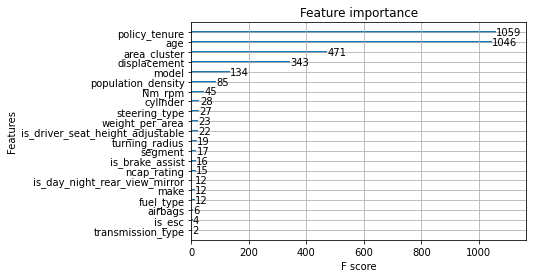

In [ ]:
model = XGBClassifier(gamma=5, learning_rate=0.01, n_estimators=500, random_state=42,max_depth=3,
                                    scale_pos_weight=round(scale_pos_weight))
model.fit(X_train_encoded, y_train)

plot_importance(model)

In [ ]:
y_pred_train = model.predict(X_train_encoded)
y_pred_train_prob = model.predict_proba(X_train_encoded)[:,1]
print('Train ')
performance(y_train,y_pred_train_prob>=0.6)
print('Test ')
X_test_encoded = ce_target.transform(X_test)
X_test_encoded = std.transform(X_test_encoded)
X_test_encoded = pd.DataFrame(X_test_encoded,columns = X_test.columns)
y_pred_test = model.predict(X_test_encoded)
y_pred_test_prob = model.predict_proba(X_test_encoded)[:,1]
performance(y_test,y_pred_test_prob >= 0.6)

Train 
f1 score  0.18274950429610046
Precision  0.11901431184762724
Recall  0.3934542867307008
Accuracy  0.7748953213180412
[[32946  8187]
 [ 1705  1106]]
Test 
f1 score  0.16751391914790612
Precision  0.10832811521603006
Recall  0.36926360725720386
Accuracy  0.7652239213544512
[[10863  2848]
 [  591   346]]


In [ ]:
test_encoded = ce_target.transform(test[num_col+cat_col])
test_encoded = std.transform(test_encoded)
test_encoded = pd.DataFrame(test_encoded,columns=X.columns)
test['prob'] = model.predict_proba(test_encoded)[:,1]
test['is_claim'] = np.where(test['prob'] > 0.6,1,0)
test[['policy_id','is_claim']].to_csv('sub_3.csv',index=0)

## Train on Complete Data for Submission

In [ ]:
ce_all = ce.TargetEncoder(cols=cat_col)
X_encoded = ce_all.fit_transform(X, y)
std_all = StandardScaler()
X_encoded = std_all.fit_transform(X_encoded)
X_encoded = pd.DataFrame(X_encoded,columns=X.columns)

/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:124: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:129: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


Train 
f1 score  0.16710072073163348
Precision  0.09424745507959281
Recall  0.7361259338313767
Accuracy  0.530584380120153
[[28329 26515]
 [  989  2759]]


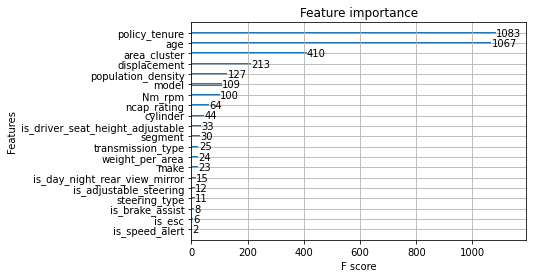

In [ ]:
model_all = XGBClassifier(gamma=5, learning_rate=0.01, n_estimators=500, random_state=42,max_depth=3,
                                    scale_pos_weight=round(scale_pos_weight))
model_all.fit(X_encoded, y)
y_pred = model_all.predict(X_encoded)
print('Train ')
performance(y,y_pred)
plot_importance(model_all)

### Check for Optimal Threshold

In [ ]:
y_pred_prob = model.predict_proba(X_encoded)[:,1]
for i in [j/100 for j in range(59,70)]:
  print(i,'-'*10)
  performance(y,y_pred_prob > i)

0.59 ----------
f1 score  0.18100724772347146
Precision  0.11787010891488503
Recall  0.38980789754535755
Accuracy  0.7743548607318406
[[43910 10934]
 [ 2287  1461]]
0.6 ----------
f1 score  0.17894663605371183
Precision  0.12103529411764706
Recall  0.3431163287086446
Accuracy  0.7985902512288368
[[45505  9339]
 [ 2462  1286]]
0.61 ----------
f1 score  0.17469348505489224
Precision  0.12484251517581033
Recall  0.29082177161152617
Accuracy  0.8242251501911524
[[47203  7641]
 [ 2658  1090]]
0.62 ----------
f1 score  0.16934893928310166
Precision  0.1288258208124652
Recall  0.24706510138740662
Accuracy  0.8449617695248498
[[48582  6262]
 [ 2822   926]]
0.63 ----------
f1 score  0.16249593760155998
Precision  0.13678643078606603
Recall  0.2001067235859125
Accuracy  0.8680536592026216
[[50111  4733]
 [ 2998   750]]
0.64 ----------
f1 score  0.14686988285678299
Precision  0.13910761154855644
Recall  0.1555496264674493
Accuracy  0.8844040141998908
[[51236  3608]
 [ 3165   583]]
0.65 ----------

### Submission

In [ ]:
test_encoded = ce_all.transform(test[num_col+cat_col])
test_encoded = std_all.transform(test_encoded)
test_encoded = pd.DataFrame(test_encoded,columns=X.columns)
test['prob'] = model_all.predict_proba(test_encoded)[:,1]
test['is_claim'] = np.where(test['prob'] >= 0.6,1,0)
test[['policy_id','is_claim']].to_csv('sub_3_all.csv',index=0)